In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_XCRD
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [7]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_XCRD
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =2e-20

nband = 1100

ng =7

ng_refs = (/ 2 , 5 /) 

nref =2

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 50 /) 

t_refs = (/ 250 , 250 /) 

tsfc =257

vstar = 1900

data w_diffuse
     &     /1.55 , 1.55 , 1.55 , 1.55,
     &     1.55 , 1.55 , 1.8/

data wgt
     &     /0.3 , 0.4 , 0.5 , 0.6,
     &     0.7 , 0.85 , 0.9/

atmosphere_profiles/saw75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

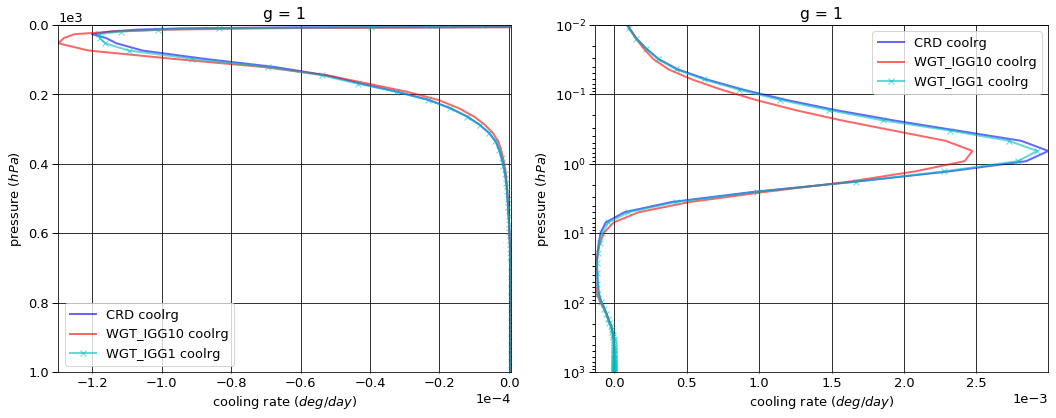

# Figure: cooling rate g-group 2

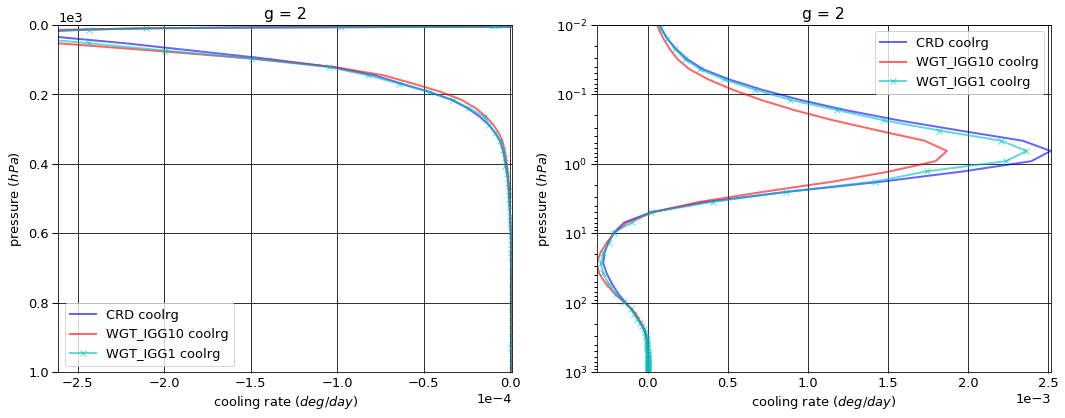

# Figure: cooling rate g-group 3

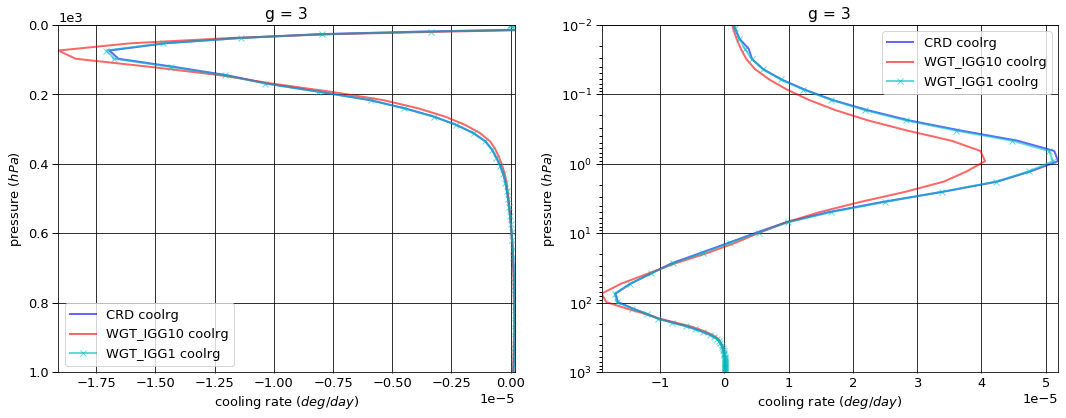

# Figure: cooling rate g-group 4

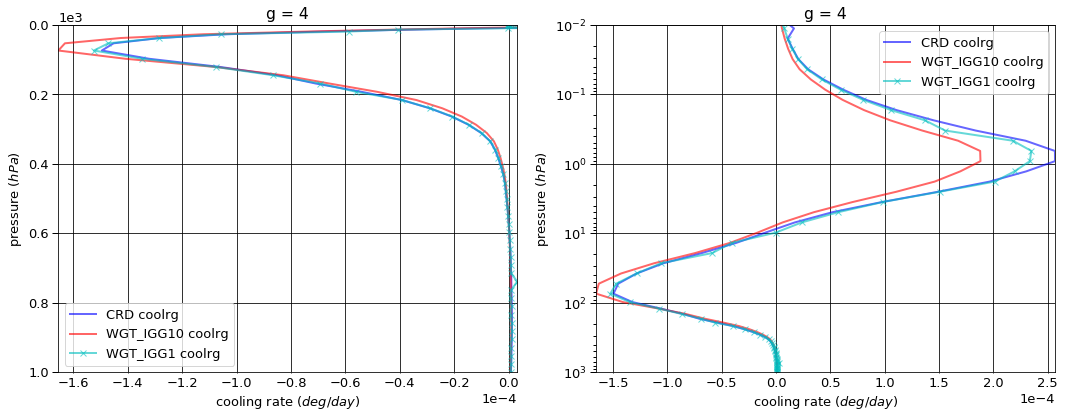

# Figure: cooling rate g-group 5

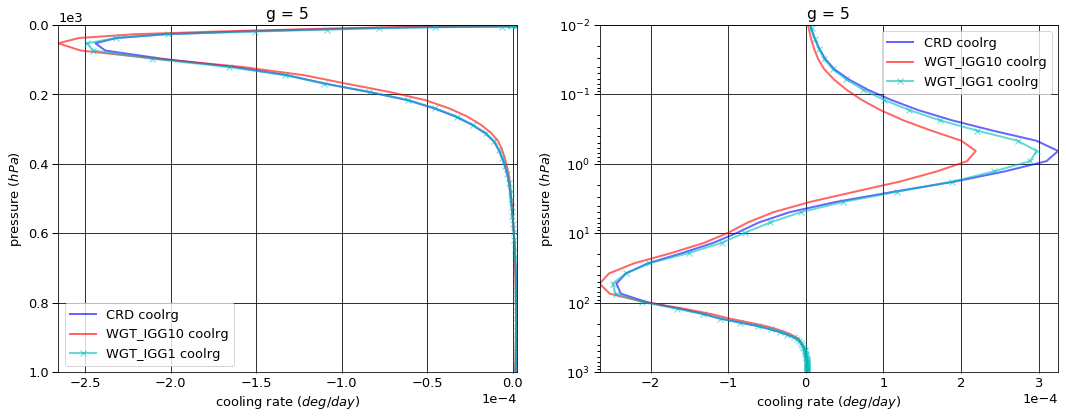

# Figure: cooling rate g-group 6

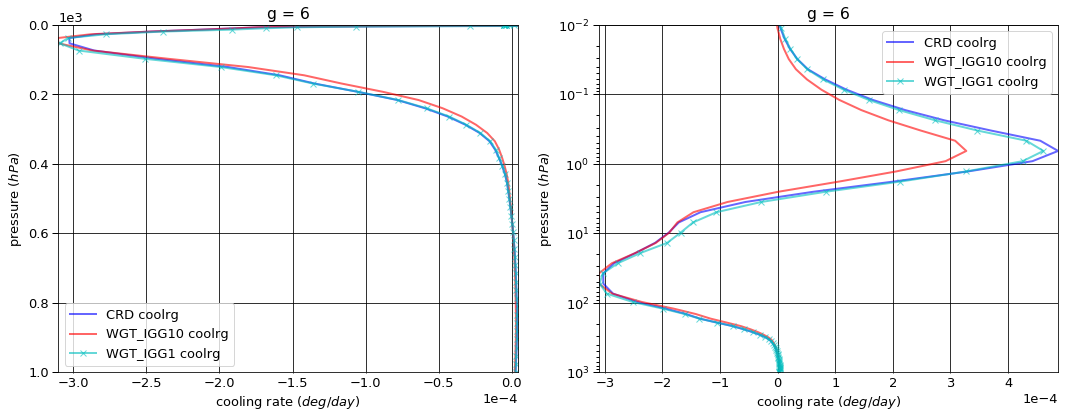

# Figure: cooling rate g-group 7

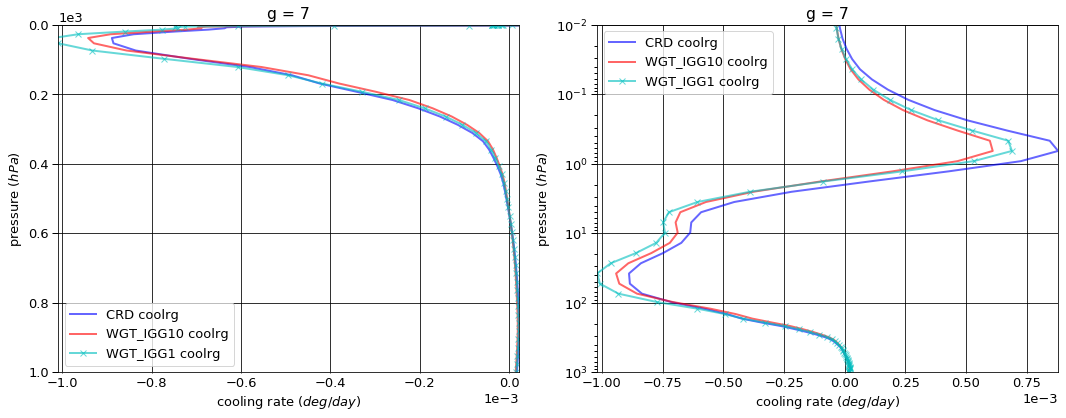

# Figure: cooling rate g-group total

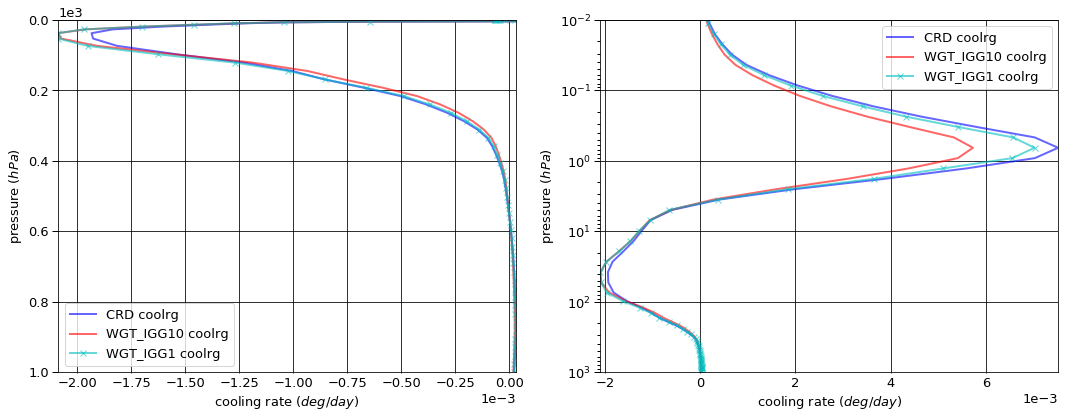

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000677  0.000000 -0.000677
  1013.0   76    -0.002287  0.000285 -0.002001
2 0.0      1     -0.001931  0.000000 -0.001931
  1013.0   76    -0.005552  0.000587 -0.004964
3 0.0      1     -0.000075  0.000000 -0.000075
  1013.0   76    -0.000438  0.000056 -0.000382
4 0.0      1     -0.001119  0.000000 -0.001119
  1013.0   76    -0.004184  0.000450 -0.003734
5 0.0      1     -0.004124  0.000000 -0.004124
  1013.0   76    -0.009306  0.000778 -0.008529
6 0.0      1     -0.010826  0.000000 -0.010826
  1013.0   76    -0.017493  0.001065 -0.016428
7 0.0      1     -1.406581  0.000000 -1.406581
  1013.0   76    -1.427648  0.003966 -1.423683


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000601  0.000000 -0.000601
  1013.0   76    -0.002287  0.000276 -0.002011
2 0.0      1     -0.001613  0.000000 -0.001613
  1013.0   76    -0.005552  0.000593 -0.004958
3 0.0      1     -0.000066  0.000000 -0.000066
  1013.0   76    -0.000438  0.000055 -0.000384
4 0.0      1     -0.001043  0.000000 -0.001043
  1013.0   76    -0.004184  0.000440 -0.003745
5 0.0      1     -0.004179  0.000000 -0.004179
  1013.0   76    -0.009306  0.000736 -0.008571
6 0.0      1     -0.011204  0.000000 -0.011204
  1013.0   76    -0.017493  0.000966 -0.016527
7 0.0      1     -1.407199  0.000000 -1.407199
  1013.0   76    -1.427648  0.003669 -1.423979


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000652  0.000000 -0.000652
  1013.0   76    -0.002287  0.000286 -0.002001
2 0.0      1     -0.001729  0.000000 -0.001729
  1013.0   76    -0.005552  0.000601 -0.004951
3 0.0      1     -0.000074  0.000000 -0.000074
  1013.0   76    -0.000438  0.000056 -0.000382
4 0.0      1     -0.001099  0.000000 -0.001099
  1013.0   76    -0.004184  0.000454 -0.003730
5 0.0      1     -0.004103  0.000000 -0.004103
  1013.0   76    -0.009306  0.000775 -0.008531
6 0.0      1     -0.010801  0.000000 -0.010801
  1013.0   76    -0.017493  0.001062 -0.016432
7 0.0      1     -1.405313  0.000000 -1.405313
  1013.0   76    -1.427648  0.004017 -1.423631


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000076  0.000000  0.000076
  1013.0   76     0.000000 -0.000009 -0.000009
2 0.0      1      0.000318  0.000000  0.000318
  1013.0   76     0.000000  0.000006  0.000006
3 0.0      1      0.000009  0.000000  0.000009
  1013.0   76     0.000000 -0.000002 -0.000002
4 0.0      1      0.000077  0.000000  0.000077
  1013.0   76     0.000000 -0.000011 -0.000011
5 0.0      1     -0.000055  0.000000 -0.000055
  1013.0   76     0.000000 -0.000042 -0.000042
6 0.0      1     -0.000377  0.000000 -0.000377
  1013.0   76     0.000000 -0.000099 -0.000099
7 0.0      1     -0.000618  0.000000 -0.000618
  1013.0   76     0.000000 -0.000296 -0.000296


WGT_IGG1 - CRD


flug          fldg         fnetg
g pressure level                                      
1 0.0      1      0.000025  0.000000e+00  2.481396e-05
  1013.0   76     0.000000  3.475300e-07  3.475000e-07
2 0.0      1      0.000201  0.000000e+00  2.013248e-04
  1013.0   76     0.000000  1.309886e-05  1.309890e-05
3 0.0      1      0.000001  0.000000e+00  1.016952e-06
  1013.0   76     0.000000  6.040000e-08  6.040000e-08
4 0.0      1      0.000020  0.000000e+00  2.030280e-05
  1013.0   76     0.000000  3.253790e-06  3.253800e-06
5 0.0      1      0.000021  0.000000e+00  2.105140e-05
  1013.0   76     0.000000 -2.218990e-06 -2.219000e-06
6 0.0      1      0.000025  0.000000e+00  2.511800e-05
  1013.0   76     0.000000 -3.545100e-06 -3.545000e-06
7 0.0      1      0.001268  0.000000e+00  1.268300e-03
  1013.0   76     0.000000  5.143050e-05  5.140000e-05

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.454172e-05
  1001.112500 75     4.638560e-07
2 0.000312    1     -1.261041e-05
  1001.112500 75     8.317566e-07
3 0.000312    1     -2.563439e-08
  1001.112500 75     1.213646e-07
4 0.000312    1     -4.086550e-07
  1001.112500 75     8.721703e-07
5 0.000312    1     -1.475989e-06
  1001.112500 75     1.643704e-06
6 0.000312    1     -4.344180e-06
  1001.112500 75     2.677253e-06
7 0.000312    1     -1.449239e-05
  1001.112500 75     1.694147e-05


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -8.266998e-06
  1001.112500 75     3.729092e-07
2 0.000312    1     -6.307876e-06
  1001.112500 75     6.715219e-07
3 0.000312    1      1.642806e-09
  1001.112500 75     9.877871e-08
4 0.000312    1     -2.708003e-07
  1001.112500 75     6.915134e-07
5 0.000312    1     -1.269966e-06
  1001.112500 75     1.309386e-06
6 0.000312    1     -4.016871e-06
  1001.112500 75     2.136662e-06
7 0.000312    1     -1.547480e-05
  1001.112500 75     1.442317e-05


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -2.056897e-05
  1001.112500 75     4.652929e-07
2 0.000312    1     -9.286106e-06
  1001.112500 75     8.397420e-07
3 0.000312    1     -1.476476e-08
  1001.112500 75     1.209055e-07
4 0.000312    1     -2.565915e-07
  1001.112500 75     8.502431e-07
5 0.000312    1     -1.097449e-06
  1001.112500 75     1.620099e-06
6 0.000312    1     -3.744410e-06
  1001.112500 75     2.639781e-06
7 0.000312    1     -1.667194e-05
  1001.112500 75     1.588712e-05


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.627472e-05
  1001.112500 75    -9.094680e-08
2 0.000312    1      6.302532e-06
  1001.112500 75    -1.602347e-07
3 0.000312    1      2.727719e-08
  1001.112500 75    -2.258588e-08
4 0.000312    1      1.378547e-07
  1001.112500 75    -1.806570e-07
5 0.000312    1      2.060230e-07
  1001.112500 75    -3.343178e-07
6 0.000312    1      3.273092e-07
  1001.112500 75    -5.405907e-07
7 0.000312    1     -9.824110e-07
  1001.112500 75    -2.518298e-06


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.972745e-06
  1001.112500 75     1.436850e-09
2 0.000312    1      3.324302e-06
  1001.112500 75     7.985430e-09
3 0.000312    1      1.086963e-08
  1001.112500 75    -4.590700e-10
4 0.000312    1      1.520635e-07
  1001.112500 75    -2.192727e-08
5 0.000312    1      3.785399e-07
  1001.112500 75    -2.360510e-08
6 0.000312    1      5.997699e-07
  1001.112500 75    -3.747230e-08
7 0.000312    1     -2.179543e-06
  1001.112500 75    -1.054353e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.425334,0.000000,-1.425334
1013.0,76,-1.466909,0.007188,-1.459721



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.425904,0.000000,-1.425904
1013.0,76,-1.466909,0.006735,-1.460174



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.423772,0.00000,-1.423772
1013.0,76,-1.466909,0.00725,-1.459659



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.00057,0.000000,-0.000570
1013.0,76,0.00000,-0.000453,-0.000453



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.001562,0.000000,0.001562
1013.0,76,0.000000,0.000062,0.000062


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000058
1001.112500,75,0.000024



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000036
1001.112500,75,0.000020



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000052
1001.112500,75,0.000022



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000022
1001.112500,75,-0.000004



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000006
1001.112500,75,-0.000001


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000791,0.001562
2,0.001895,0.003794
3,0.000155,0.000299
4,0.001450,0.002858
5,0.003195,0.006359
6,0.005945,0.011958
7,0.986568,0.973170


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.170995e-19
2,1.046602e-19
3,1.656130e-19
4,8.186633e-20
5,4.046841e-20
6,2.000446e-20
7,1.234195e-27


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.170995e-19,NaN,0.000791,0.001562,0.000791,0.001562,1.0
2,1.046602e-19,2.509238e-01,0.001895,0.003794,0.002686,0.005356,1.0
3,1.656130e-19,1.582388e+00,0.000155,0.000299,0.002841,0.005655,50.0
4,8.186633e-20,4.943230e-01,0.001450,0.002858,0.004291,0.008513,50.0
5,4.046841e-20,4.943230e-01,0.003195,0.006359,0.007486,0.014872,50.0
6,2.000446e-20,4.943230e-01,0.005945,0.011958,0.013432,0.026830,50.0
7,1.234195e-27,6.169600e-08,0.986568,0.973170,1.000000,1.000000,50.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog          ratio        taulyr
layer g pressure                                                            
1     1 0.000312     8.050662e-19  7.219069e-19       1.115194  1.601236e-06
      2 0.000312     2.125311e-19  1.706843e-19       1.245171  4.018297e-07
      3 0.000312     2.895521e-20  2.765102e-20       1.047166  6.068109e-08
      4 0.000312     1.621645e-20  1.386568e-20       1.169539  3.275163e-08
      5 0.000312     1.155442e-20  7.509832e-21       1.538573  2.217092e-08
      6 0.000312     1.141775e-20  5.604899e-21       2.037101  2.260995e-08
      7 0.000312     2.782914e-22  1.698681e-27  163827.910000  5.369845e-10
2     1 0.000750     8.008560e-19  7.195683e-19       1.112967  7.475718e-07
      2 0.000750     2.128351e-19  1.714019e-19       1.241731  1.888892e-07
      3 0.000750     2.938403e-20  2.805411e-20       1.047405  2.885871e-08
      4 0.000750     1.643931e-20  1.404475e-20       1.170495  1.555676e-08
      5 0.000750     1.167937e-20  7.580484e-21       1.540715  1.050051e-08
      6 0.000750     1.151495e-20  5.645957e-21       2.039504  1.068631e-08
      7 0.000750     2.814183e-22  1.754799e-27  160370.630000  2.545081e-10
3     1 0.001052     7.923706e-19  7.147352e-19       1.108621  1.336847e-06
      2 0.001052     2.134222e-19  1.728132e-19       1.234988  3.424542e-07
      3 0.001052     3.024785e-20  2.886572e-20       1.047882  5.353864e-08
      4 0.001052     1.688926e-20  1.440507e-20       1.172453  2.879298e-08
      5 0.001052     1.193251e-20  7.722373e-21       1.545187  1.932649e-08
      6 0.001052     1.171257e-20  5.728388e-21       2.044653  1.958999e-08
      7 0.001052     2.878715e-22  1.792112e-27  160632.580000  4.693013e-10
4     1 0.001476     7.837759e-19  7.096758e-19       1.104414  2.283047e-06
      2 0.001476     2.139771e-19  1.741894e-19       1.228416  5.929963e-07
      3 0.001476     3.113180e-20  2.969621e-20       1.048343  9.487095e-08
      4 0.001476     1.735064e-20  1.477377e-20       1.174422  5.090692e-08
      5 0.001476     1.219182e-20  7.866898e-21       1.549762  3.398292e-08
      6 0.001476     1.191481e-20  5.811947e-21       2.050055  3.431057e-08
      7 0.001476     2.946061e-22  1.837947e-27  160290.860000  8.270736e-10
5     1 0.002070     7.751812e-19  7.044570e-19       1.100395  3.776889e-06
      2 0.002070     2.144914e-19  1.755106e-19       1.222099  9.946264e-07
      3 0.002070     3.202497e-20  3.053540e-20       1.048782  1.628028e-07
      4 0.002070     1.781782e-20  1.514642e-20       1.176371  8.717425e-08
      5 0.002070     1.245408e-20  8.012336e-21       1.554363  5.788395e-08
      6 0.002070     1.211912e-20  5.895621e-21       2.055614  5.821725e-08
      7 0.002070     3.015458e-22  1.892185e-27  159363.840000  1.412501e-09
6     1 0.002904     7.665882e-19  6.990853e-19       1.096559  6.109373e-06
      2 0.002904     2.149643e-19  1.767752e-19       1.216032  1.631102e-06
      3 0.002904     3.292743e-20  3.138343e-20       1.049198  2.730983e-07
      4 0.002904     1.829090e-20  1.552318e-20       1.178296  1.459433e-07
      5 0.002904     1.271927e-20  8.158779e-21       1.558968  9.640589e-08
      6 0.002904     1.232540e-20  5.979449e-21       2.061294  9.659601e-08
      7 0.002904     3.086947e-22  1.956619e-27  157769.460000  2.359591e-09
7     1 0.004074     7.579178e-19  6.934994e-19       1.092889  9.712111e-06
      2 0.004074     2.153723e-19  1.779658e-19       1.210189  2.628615e-06
      3 0.004074     3.383603e-20  3.223753e-20       1.049585  4.501202e-07
      4 0.004074     1.876814e-20  1.590293e-20       1.180169  2.400973e-07
      5 0.004074     1.298606e-20  8.305834e-21       1.563487  1.578026e-07
      6 0.004074     1.253226e-20  6.063193e-21       2.066941  1.575288e-07
      7 0.004074     3.160239e-22  2.033522e-27  155407.120000  3.875194e-09
8     1 0.005714     7.490825e-19  6.876293e-19       1.089370  1.522812e-05
      2 0.005714     2

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
